In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import utilities

COLORS = utilities.COLORS

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print('_____Train dataset_____')
df_train.head()

_____Train dataset_____


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
print('_____Test dataset_____')
df_test.head()

_____Test dataset_____


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


## Sum up of what we know about the data:

* **FAVC** (Frequent consumption of high caloric food): This attribute indicates how often an individual consumes high-calorie food items like fast food, sugary snacks, or processed foods. It can provide insights into dietary habits that may contribute to obesity.

* **FCVC** (Frequency of consumption of vegetables): FCVC represents how often an individual consumes vegetables as part of their diet. High consumption of vegetables is often associated with a healthier diet and lower obesity risk due to their nutrient density and low calorie content.

* **NCP** (Number of main meals): NCP denotes the number of main meals an individual consumes per day. This attribute provides information about eating patterns and meal frequency, which can influence metabolism and weight management.

* **CAEC** (Consumption of food between meals): CAEC indicates the frequency or amount of food consumption between main meals. Snacking habits can impact overall calorie intake and contribute to weight gain if unhealthy snacks are consumed frequently.

* **CH2O** (Consumption of water daily): CH2O represents the daily consumption of water by an individual. Proper hydration is important for overall health and can indirectly influence weight management by reducing calorie intake and promoting metabolic function.

* **CALC** (Consumption of alcohol): CALC denotes the frequency or amount of alcohol consumption by an individual. Alcohol contributes calories to the diet and can affect metabolism, potentially leading to weight gain or obesity if consumed excessively.

* **SCC** (Calories consumption monitoring): SCC indicates whether an individual monitors their calorie intake. This attribute reflects awareness of dietary habits and can be used to assess adherence to calorie goals for weight management.

* **FAF** (Physical activity frequency): FAF represents how often an individual engages in physical activity or exercise. Regular physical activity is essential for maintaining a healthy weight, improving metabolic health, and reducing the risk of obesity-related diseases.

* **TUE** (Time using technology devices): TUE indicates the amount of time an individual spends using technological devices such as smartphones, computers, or television. Sedentary behavior associated with excessive screen time can contribute to a sedentary lifestyle and increase the risk of obesity.

* **MTRANS** (Transportation used): MTRANS denotes the mode of transportation predominantly used by an individual, such as walking, cycling, public transport, or private vehicle. Transportation choices can influence physical activity levels and overall energy expenditure, impacting weight management and obesity risk.

In [6]:
weight_cat = np.unique(df_train['NObeyesdad'])
print(weight_cat)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [7]:
# Add BMI column
df_train['BMI'] = df_train['Weight'] / (df_train['Height']) ** 2
df_test['BMI'] = df_test['Weight'] / (df_test['Height']) ** 2

In [8]:
# Get type of each column
df_train.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
BMI                               float64
dtype: object

We must notice some data are object but are boolean in reality: _Gender_, _family_history_with_overweight_, _FAVC_, _SCC_, _SMOKE_

## Missing data

We're now cheacking for missing data:

In [9]:
# Check for missing values
print(df_train.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
dtype: int64


Dataset is clean, no missing data

## Data distribution

We now turn our attention to data distribution.
Checking the distribution of each category in a dataset is really important:
- **_Data Quality Assessment:_** It helps in assessing the quality of the dataset. Identifying imbalanced distributions or missing categories can indicate issues with data collection or processing.

- **_Bias Detection:_** Examining category distributions can reveal biases present in the data. Biases may arise due to sampling methods, data collection procedures, or inherent societal biases. Identifying biases is crucial for building fair and unbiased models.

- **_Model Performance:_** Imbalanced category distributions can adversely affect the performance of machine learning models, particularly in classification tasks. Models trained on imbalanced data may exhibit biases towards majority classes and perform poorly on minority classes. Understanding the distribution helps in applying appropriate techniques such as resampling or adjusting class weights to mitigate these issues.

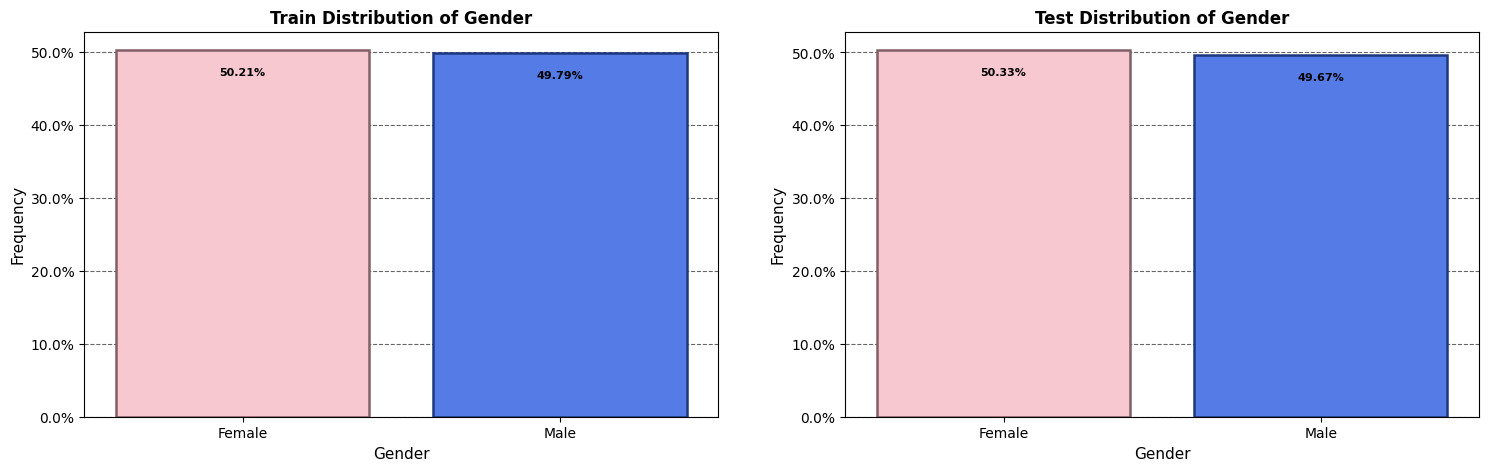

In [10]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'Gender', color=[COLORS['PINK'], COLORS['BLUE']], frequency=True, title_before='Train ')
ax = plt.subplot(1, 2, 2)
_ = utilities.plot_hist_discrete_feature(ax, df_test, 'Gender', color=[COLORS['PINK'], COLORS['BLUE']], frequency=True, title_before='Test ')

The sex is well distributed in our dataset

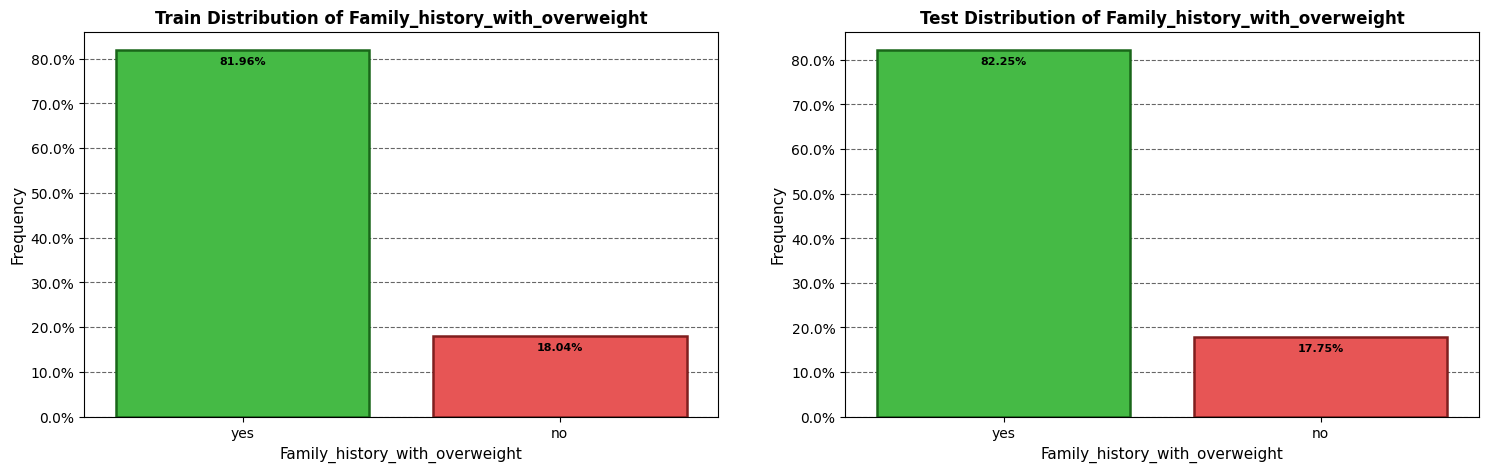

In [11]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'family_history_with_overweight', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Train ')
ax = plt.subplot(1, 2, 2)
_ = utilities.plot_hist_discrete_feature(ax, df_test, 'family_history_with_overweight', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Test ')

There is a strong bias towards 'yes', we must keep it in mind

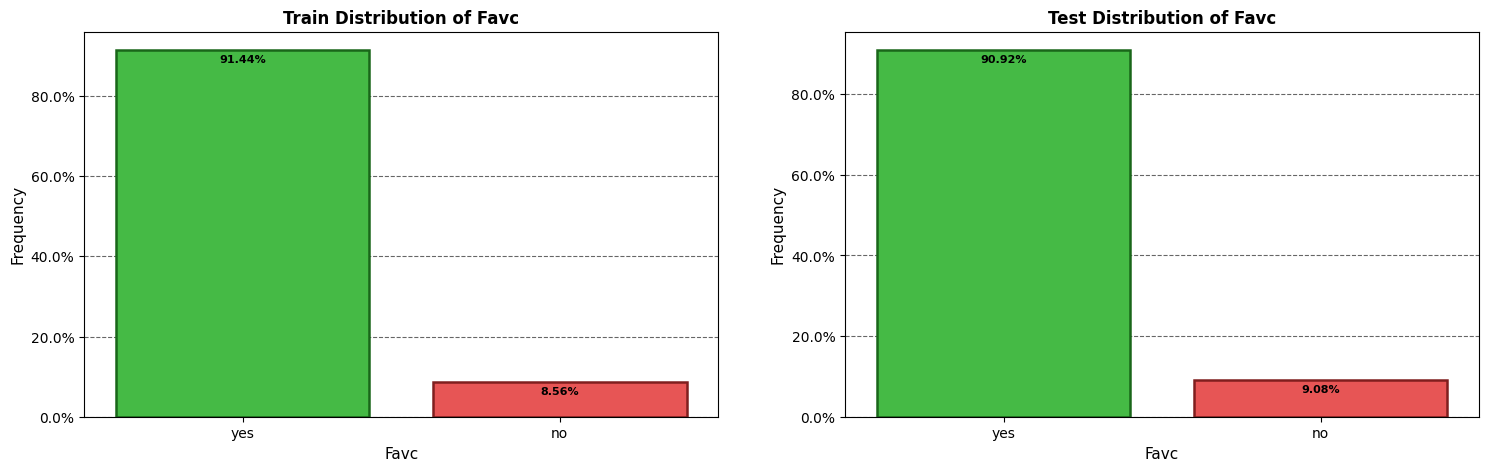

In [12]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'FAVC', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Train ')
ax = plt.subplot(1, 2, 2)
_ = utilities.plot_hist_discrete_feature(ax, df_test, 'FAVC', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Test ')

Here there is also a strong bias

For the next categories _'FCVC'_, _'NPC'_ that represents 'meals' per day we could afford a loss of precision by roundint them at the unit

In [13]:
# Define function to round column
def round_column(df: pd.DataFrame, 
                 column: str, 
                 n_decimals: int = 0) -> pd.DataFrame:
    
    df[column] = df[column].round(n_decimals)
    return df

# Round columns 'FCVC' and 'NCP' to 1 decimal
df_train = round_column(df_train, 'FCVC')
df_train = round_column(df_train, 'NCP')
df_test = round_column(df_test, 'FCVC')
df_test = round_column(df_test, 'NCP')

# print unique values of 'FCVC' and 'NCP' for train dataset
print(f'{np.unique(df_train["FCVC"]) = }')
print(f'{np.unique(df_train["NCP"]) = }')

# print unique values of 'FCVC' and 'NCP' for test dataset
print(f'{np.unique(df_test["FCVC"]) = }')
print(f'{np.unique(df_test["NCP"]) = }')

np.unique(df_train["FCVC"]) = array([1., 2., 3.])
np.unique(df_train["NCP"]) = array([1., 2., 3., 4.])
np.unique(df_test["FCVC"]) = array([1., 2., 3.])
np.unique(df_test["NCP"]) = array([1., 2., 3., 4.])


Now we can visualize!

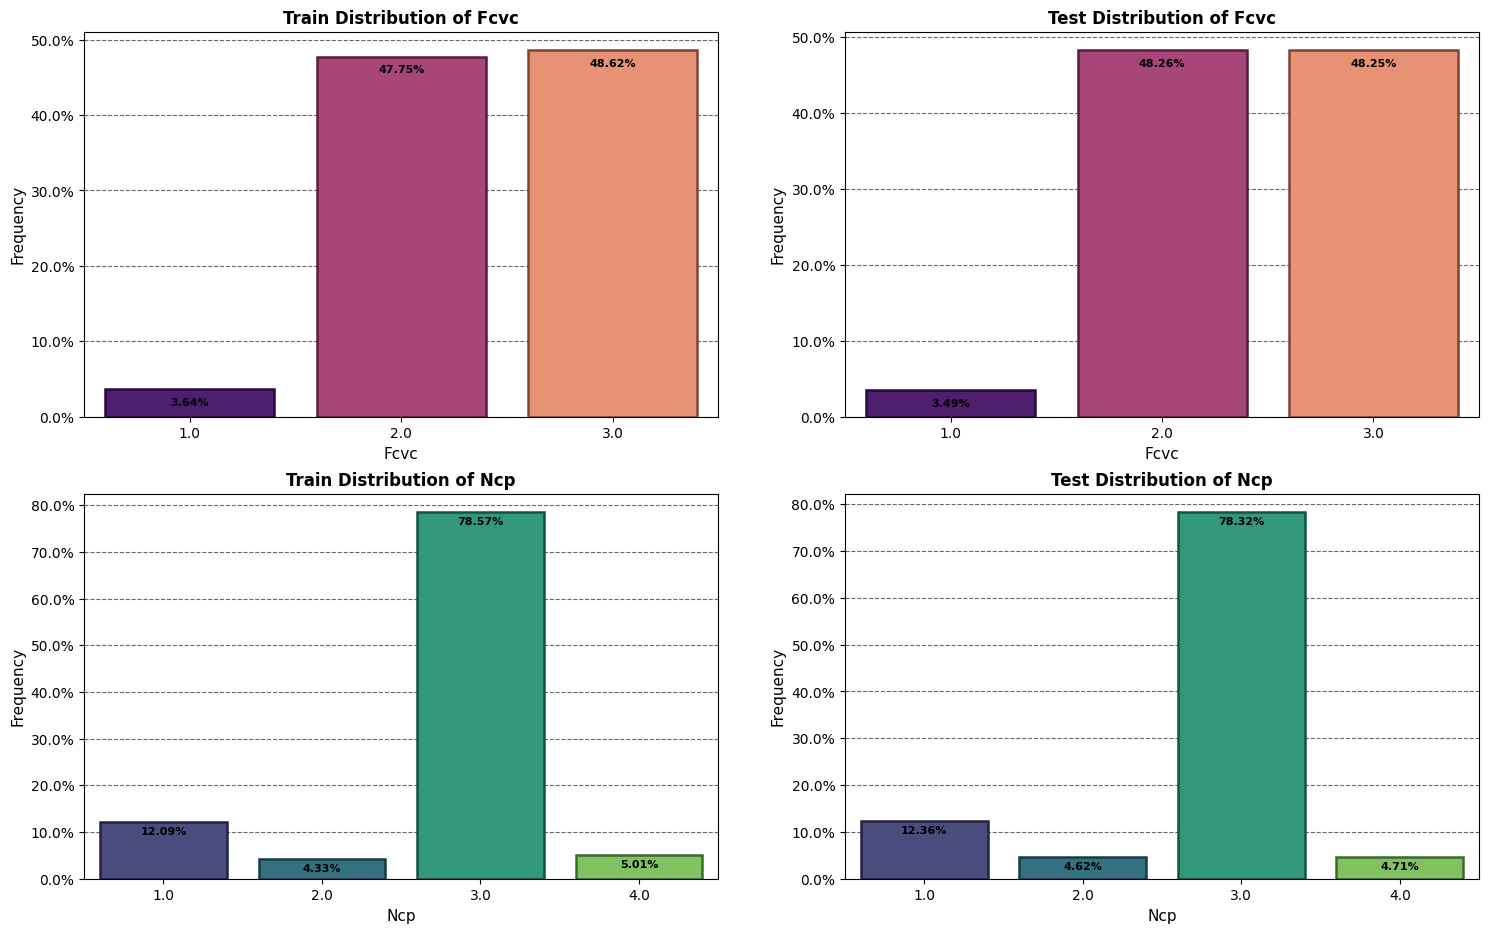

In [14]:
plt.figure(figsize=(18, 11))
ax = plt.subplot(2, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'FCVC', frequency=True, color='magma', title_before='Train ')
ax = plt.subplot(2, 2, 2)
utilities.plot_hist_discrete_feature(ax, df_test, 'FCVC', frequency=True, color='magma', title_before='Test ')
ax = plt.subplot(2, 2, 3)
utilities.plot_hist_discrete_feature(ax, df_train, 'NCP', frequency=True, percentage_label=14, color='viridis', title_before='Train ')
ax = plt.subplot(2, 2, 4)
_ = utilities.plot_hist_discrete_feature(ax, df_test, 'NCP', frequency=True, percentage_label=14, color='viridis', title_before='Test ')

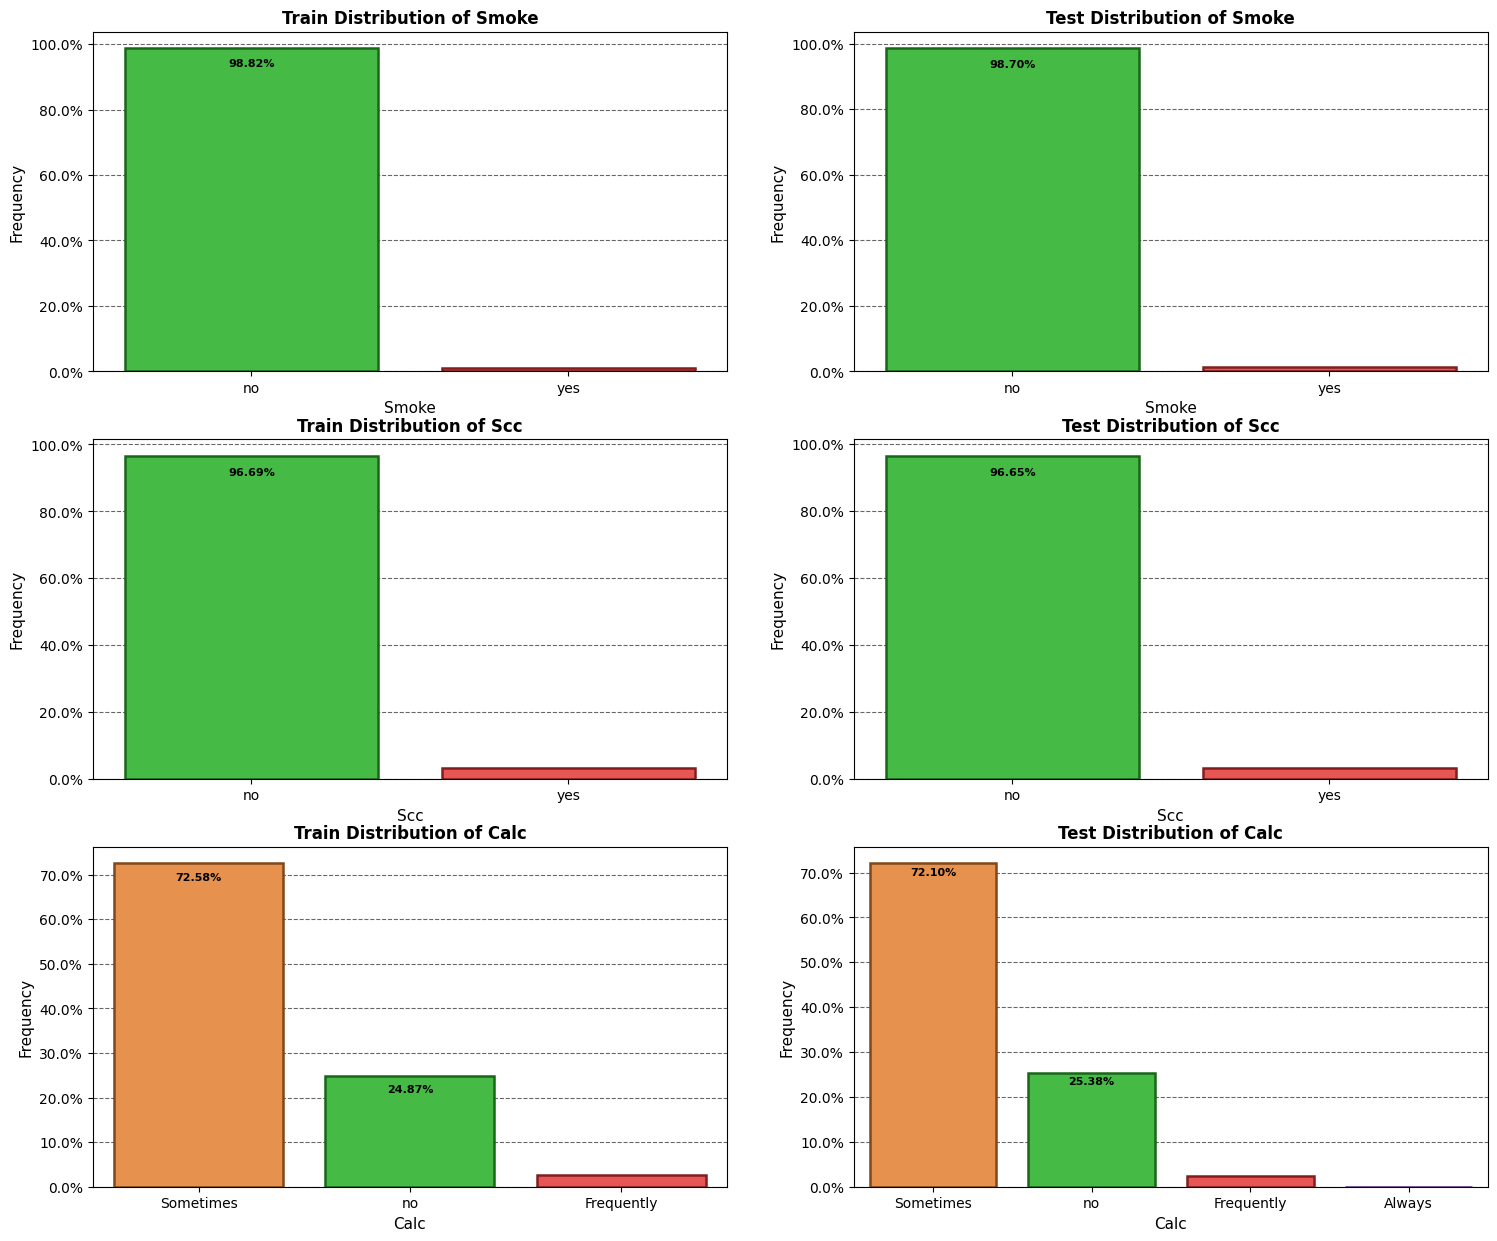

In [15]:
plt.figure(figsize=(18, 15))
ax = plt.subplot(3, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'SMOKE', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Train ', percentage_label=14)
ax = plt.subplot(3, 2, 2)
utilities.plot_hist_discrete_feature(ax, df_test, 'SMOKE', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Test ', percentage_label=14)
ax = plt.subplot(3, 2, 3)
utilities.plot_hist_discrete_feature(ax, df_train, 'SCC', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Train ', percentage_label=14)
ax = plt.subplot(3, 2, 4)
utilities.plot_hist_discrete_feature(ax, df_test, 'SCC', color=[COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Test ', percentage_label=14)
ax = plt.subplot(3, 2, 5)
utilities.plot_hist_discrete_feature(ax, df_train, 'CALC', color=[COLORS['ORANGE'], COLORS['GREEN'], COLORS['RED']], frequency=True, title_before='Train ', percentage_label=14)
ax = plt.subplot(3, 2, 6)
data = utilities.plot_hist_discrete_feature(ax, df_test, 'CALC', color=[COLORS['ORANGE'], COLORS['GREEN'], COLORS['RED'], COLORS['PURPLE']], frequency=True, title_before='Test ', percentage_label=14)

The data for this columns seems really imbalanced we must keept it in mind. Moreover another category for _'CALC'_ exist in the test_set (_Always_):

In [16]:
print(data)

       Labels  Counts  Percentages
2   Sometimes    9979    72.102601
3          no    3513    25.382948
1  Frequently     346     2.500000
0      Always       2     0.014451


It seems really scarce, so we may fusion it with _Frequently_

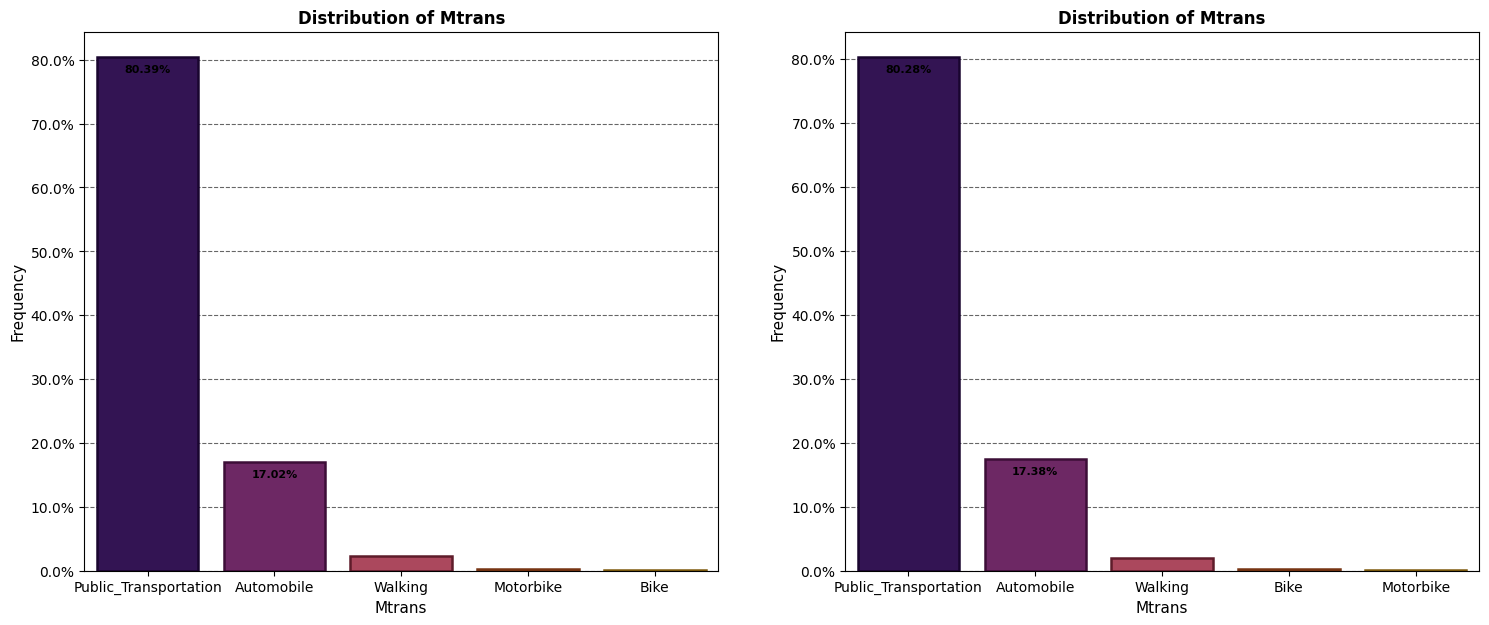

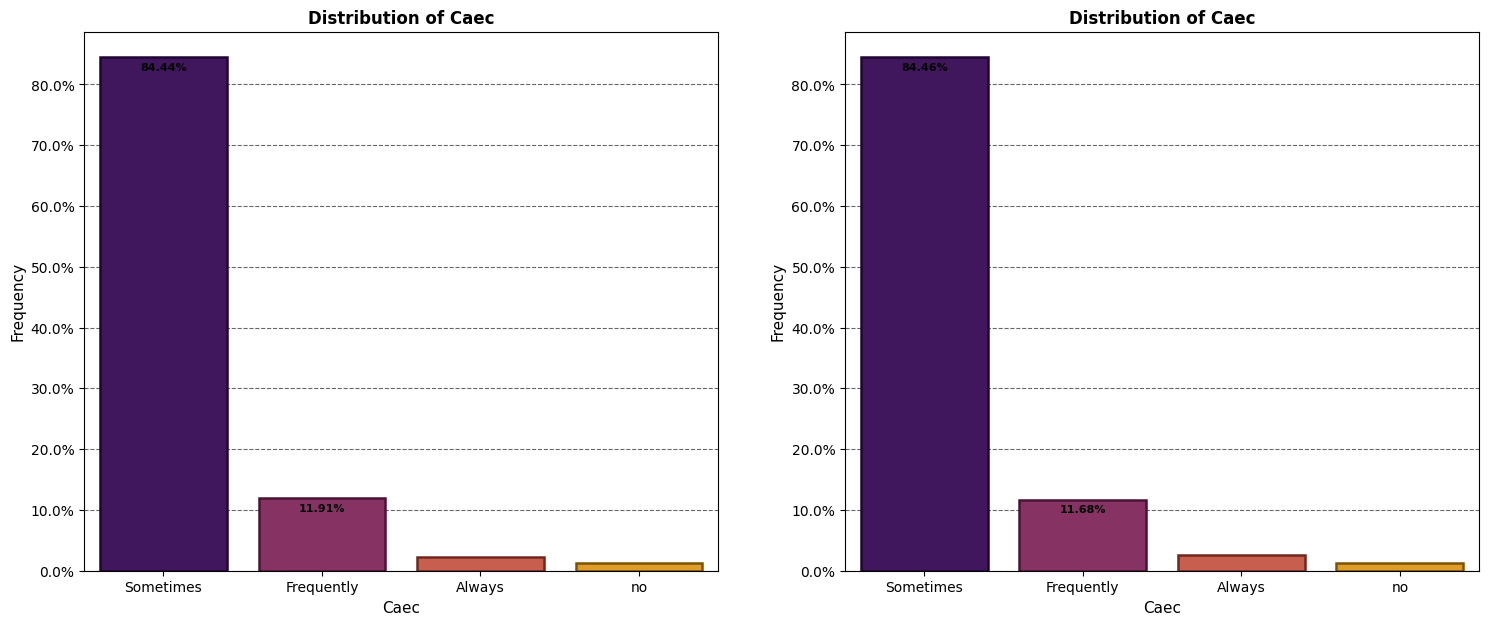

In [17]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'MTRANS', color='inferno', frequency=True, percentage_label=15)
ax = plt.subplot(1, 2, 2)
utilities.plot_hist_discrete_feature(ax, df_test, 'MTRANS', color='inferno', frequency=True, percentage_label=15)

plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 2, 1)
utilities.plot_hist_discrete_feature(ax, df_train, 'CAEC', color='inferno', frequency=True, percentage_label=11)
ax = plt.subplot(1, 2, 2)
_ = utilities.plot_hist_discrete_feature(ax, df_test, 'CAEC', color='inferno', frequency=True, percentage_label=11)

Here again _Bike_, _Motorbike_ and _Always_ seems really scarce, we may fusion it with respectively _Automobil_ and _Frequently_

Finally the distribution of our target:

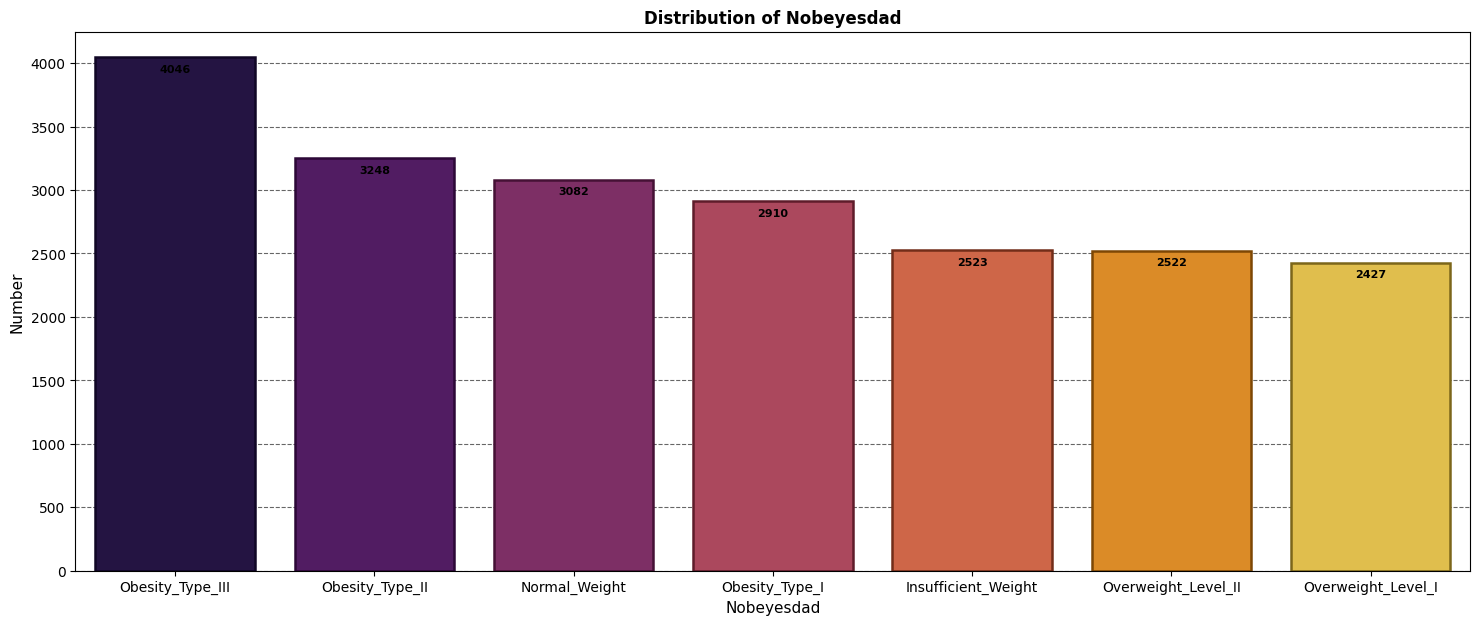

                Labels  Counts  Percentages
4     Obesity_Type_III    4046    19.491280
3      Obesity_Type_II    3248    15.646979
1        Normal_Weight    3082    14.847288
2       Obesity_Type_I    2910    14.018692
0  Insufficient_Weight    2523    12.154350
6  Overweight_Level_II    2522    12.149533
5   Overweight_Level_I    2427    11.691878


In [18]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 1, 1)
data = utilities.plot_hist_discrete_feature(ax, df_train, 'NObeyesdad', color='inferno', frequency=False, percentage_label=5)
plt.show()
print(data)

The data is a little bit imbalenced but all the classes are well represented which is important!

## Data Correlation

We will now look how features are linked to the target we're trying to predict

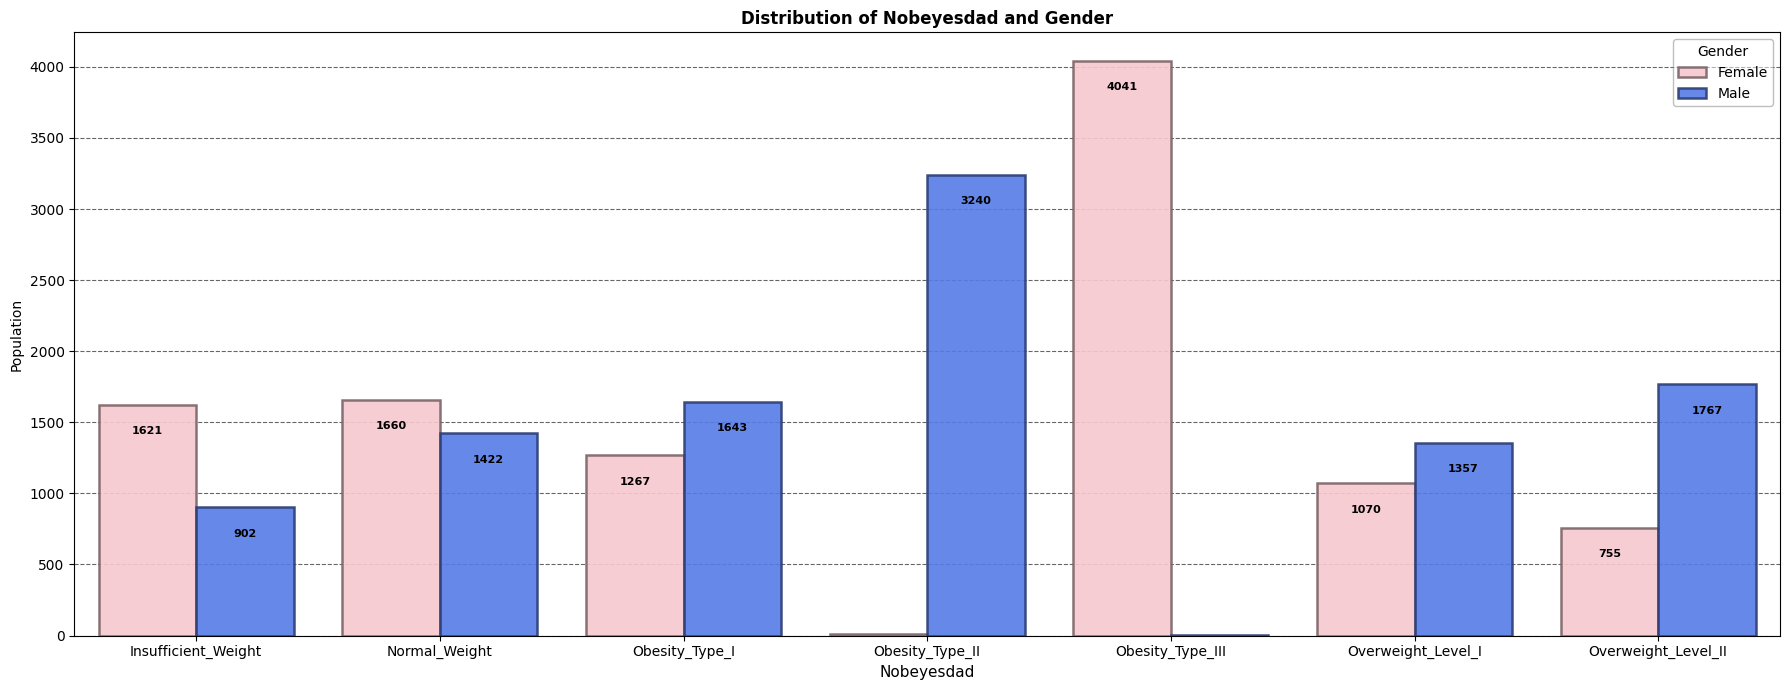

In [19]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 1, 1)
_ = utilities.plot_groupby(ax, df_train, 'NObeyesdad', 'Gender', color=[COLORS['PINK'], COLORS['BLUE']], style='multibar')

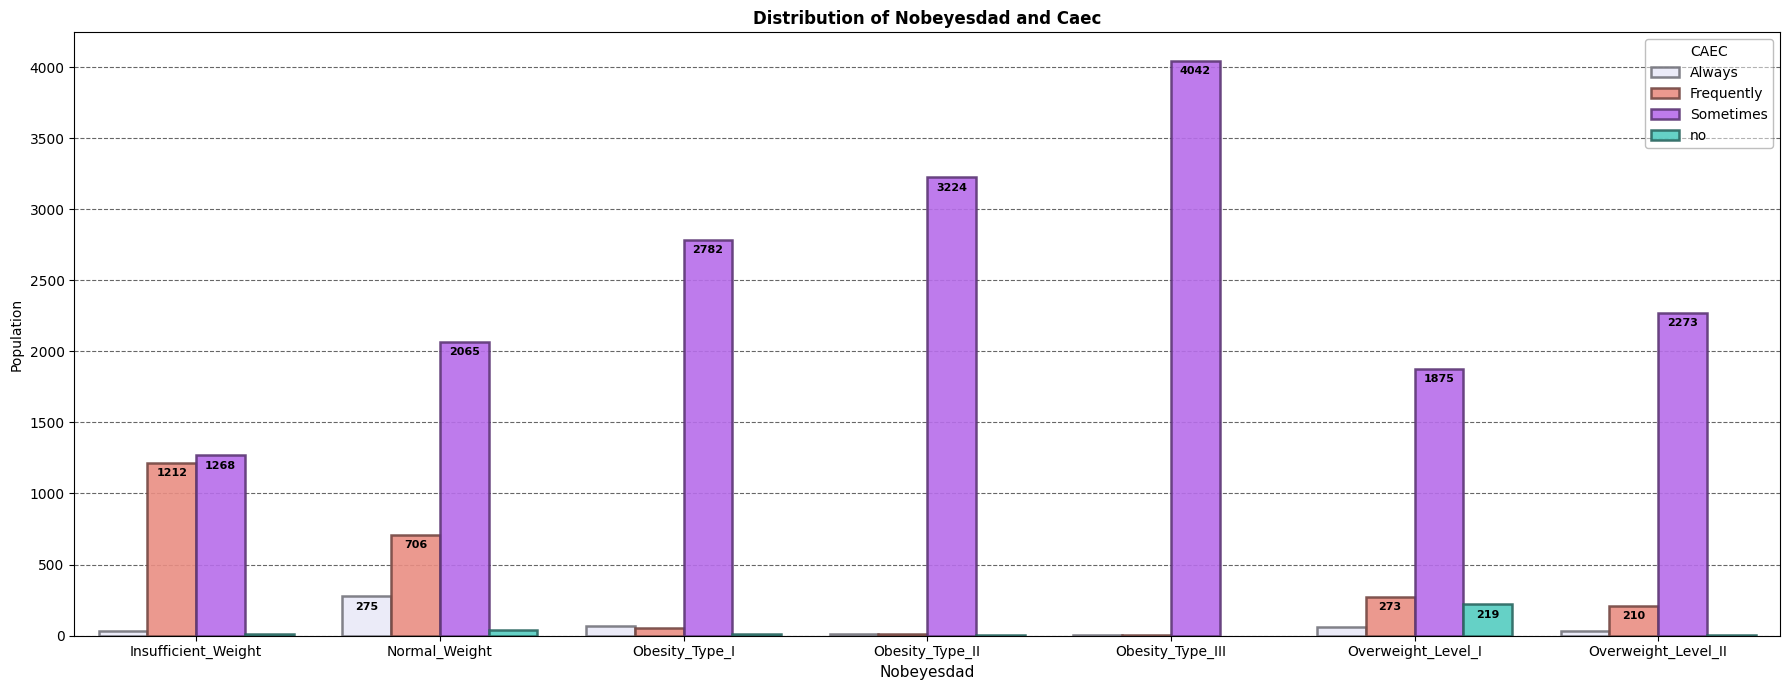

In [20]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 1, 1)
_ = utilities.plot_groupby(ax, df_train, 'NObeyesdad', 'CAEC', color='random', style='multibar')

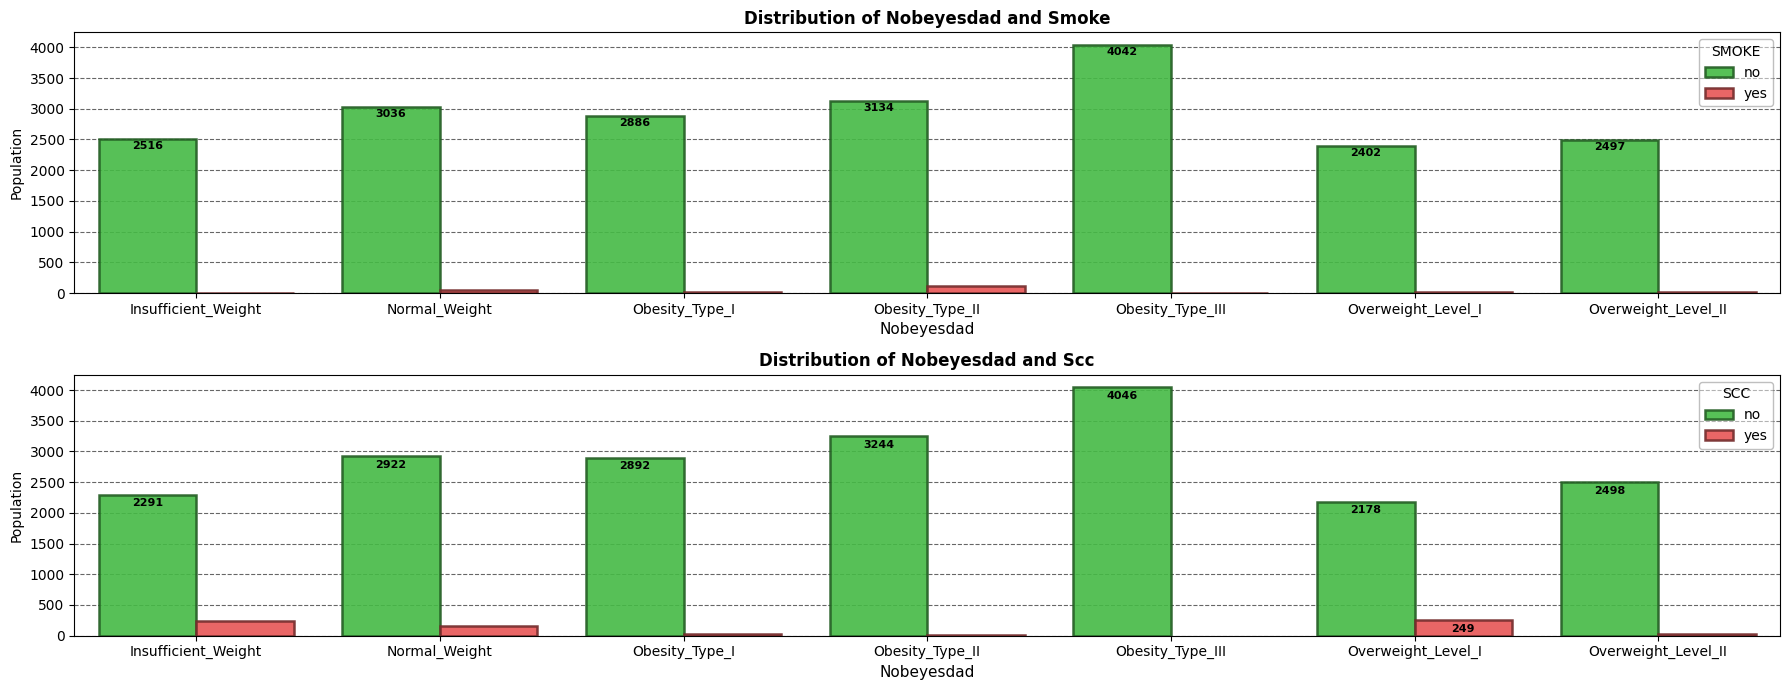

In [21]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(2, 1, 1)
_ = utilities.plot_groupby(ax, df_train, 'NObeyesdad', 'SMOKE', color=[COLORS['GREEN'], COLORS['RED']], style='multibar')
ax = plt.subplot(2, 1, 2)
_ = utilities.plot_groupby(ax, df_train, 'NObeyesdad', 'SCC', color=[COLORS['GREEN'], COLORS['RED']], style='multibar')

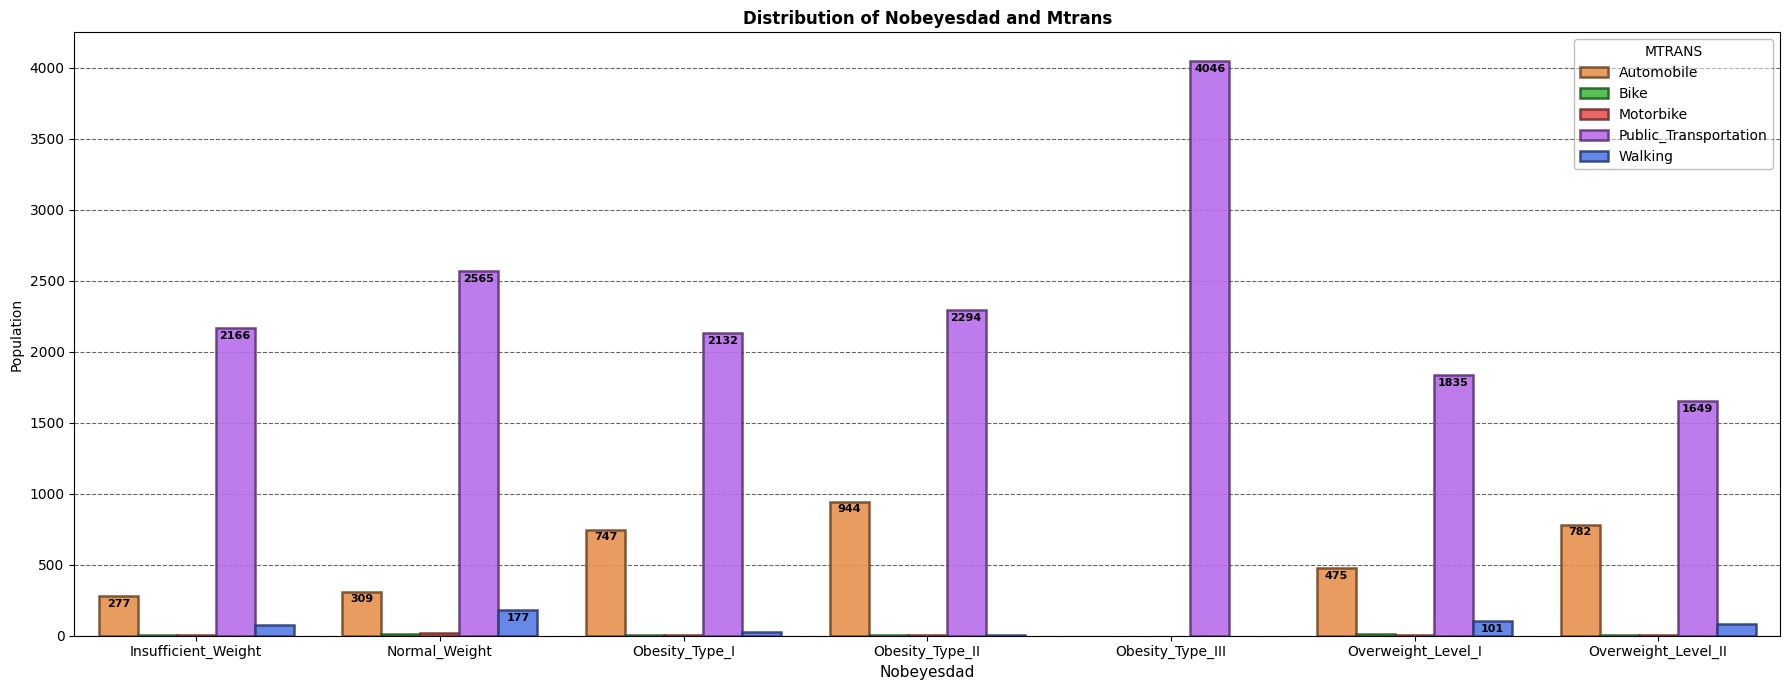

In [22]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 1, 1)
_ = utilities.plot_groupby(ax, df_train, 'NObeyesdad', 'MTRANS', color=[COLORS['ORANGE'], COLORS['GREEN'], COLORS['RED'], COLORS['PURPLE'], COLORS['BLUE']], style='multibar')

7


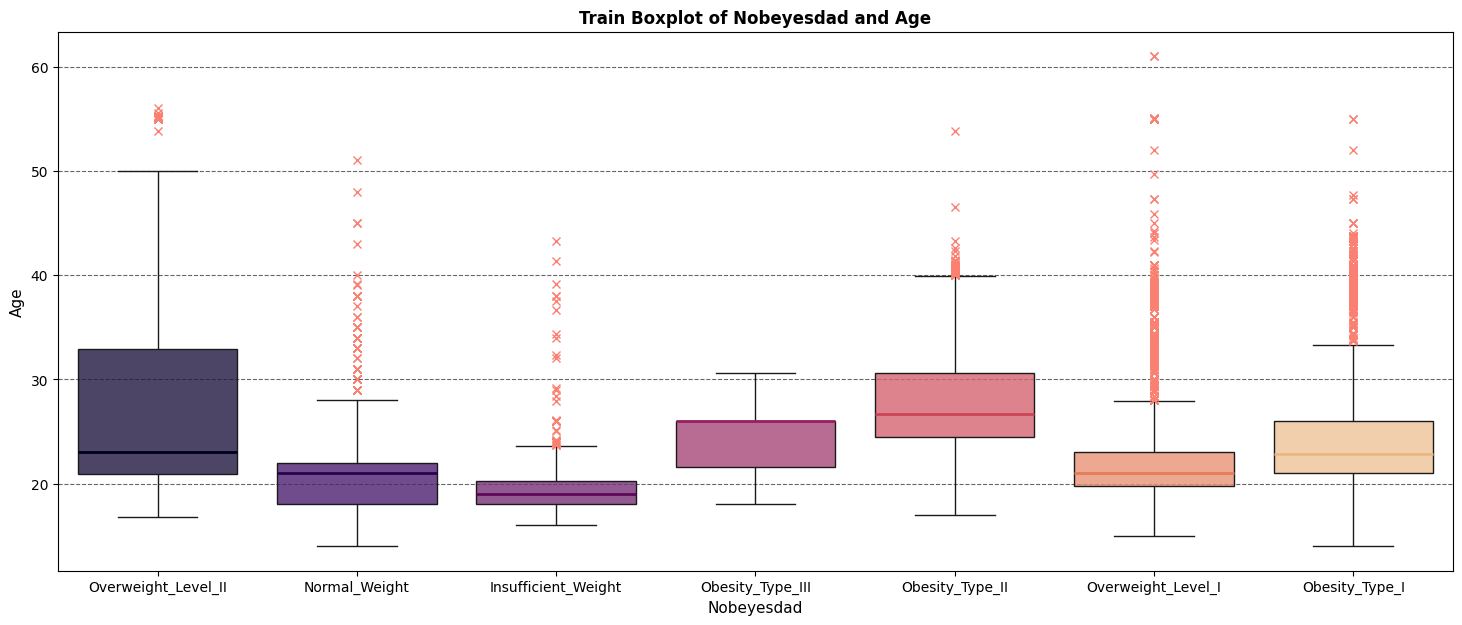

In [23]:
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 1, 1)
utilities.plot_boxplot(ax, df_train, 'NObeyesdad', 'Age', color='magma', title_before='Train ', median_style={'linewidth': 2}, outlier_style={'marker': 'x', 'markeredgecolor':'salmon'})

In [24]:
df_train

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.0,3.0,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.0,3.0,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,2,Female,18.000000,1.711460,50.165754,yes,yes,2.0,1.0,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.0,3.0,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,4,Male,31.641081,1.914186,93.798055,yes,yes,3.0,2.0,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,3.0,3.0,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.0,4.0,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.0,3.0,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,3.0,2.0,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693


In [25]:
# convert Gender to binary
df_train['Gender'] = df_train['Gender'].map({'Male': 1, 'Female': 0})
df_test['Gender'] = df_test['Gender'].map({'Male': 1, 'Female': 0})

# convert age to categorical
df_train['Age'] = pd.cut(df_train['Age'], bins=[0, 18, 30, 40, 50, 60, 70, 80], labels=['0-18', '18-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
df_test['Age'] = pd.cut(df_test['Age'], bins=[0, 18, 30, 40, 50, 60, 70, 80], labels=['0-18', '18-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

# convert BMI to categorical
df_train['BMI'] = pd.cut(df_train['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 60], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'])
df_test['BMI'] = pd.cut(df_test['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 60], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'])

# convert family_history_with_overweight to binary (yes=1, no=0)
df_train['family_history_with_overweight'] = df_train['family_history_with_overweight'].map({'yes': 1, 'no': 0})
df_test['family_history_with_overweight'] = df_test['family_history_with_overweight'].map({'yes': 1, 'no': 0})

# convert SMOKE to binary (yes=1, no=0)
df_train['SMOKE'] = df_train['SMOKE'].map({'yes': 1, 'no': 0})
df_test['SMOKE'] = df_test['SMOKE'].map({'yes': 1, 'no': 0})

# convert SCC to binary (yes=1, no=0)
df_train['SCC'] = df_train['SCC'].map({'yes': 1, 'no': 0})
df_test['SCC'] = df_test['SCC'].map({'yes': 1, 'no': 0})

# convert FAVC to binary (yes=1, no=0)
df_train['FAVC'] = df_train['FAVC'].map({'yes': 1, 'no': 0})
df_test['FAVC'] = df_test['FAVC'].map({'yes': 1, 'no': 0})

# convert CALC to binary (always=3, frequently=2, sometimes=1, no=0)
df_train['CALC'] = df_train['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
df_test['CALC'] = df_test['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})

# convert CAEC to binary (no=0, Sometimes=1, Frequently=2, Always=3)
df_train['CAEC'] = df_train['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df_test['CAEC'] = df_test['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

# convert MTRANS to dummy variables with fusioning motobike and bike into automobile
df_train = pd.get_dummies(df_train, columns=['MTRANS'])
df_test = pd.get_dummies(df_test, columns=['MTRANS'])

# round CH2O to 0 decimals
df_train = round_column(df_train, 'CH2O')
df_test = round_column(df_test, 'CH2O')

# round TUE to 1 decimal
df_train = round_column(df_train, 'TUE', n_decimals=1)
df_test = round_column(df_test, 'TUE', n_decimals=1)

# round FAF to 1 decimal
df_train = round_column(df_train, 'FAF', n_decimals=1)
df_test = round_column(df_test, 'FAF', n_decimals=1)

# Put BMI and Age to numerical values
df_train['BMI'] = df_train['BMI'].cat.codes
df_train['Age'] = df_train['Age'].cat.codes
df_test['BMI'] = df_test['BMI'].cat.codes
df_test['Age'] = df_test['Age'].cat.codes

# delete height and weight columns
df_train = df_train.drop(['Height', 'Weight'], axis=1)
df_test = df_test.drop(['Height', 'Weight'], axis=1)

# drop motorbike and bike columns
# df_train = df_train.drop(['MTRANS_Motorbike', 'MTRANS_Bike'], axis=1)
# df_test = df_test.drop(['MTRANS_Motorbike', 'MTRANS_Bike'], axis=1)

In [26]:
# convert NObeyesdad to numerical values
df_train['NObeyesdad'] = df_train['NObeyesdad'].map({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

In [27]:
df_train

,id,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,...,FAF,TUE,CALC,NObeyesdad,BMI,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,1,1,1,1,2.0,3.0,1,0,3.0,...,0.0,1.0,1,3,2,False,False,False,True,False
1,1,0,0,1,1,2.0,3.0,2,0,2.0,...,1.0,1.0,0,1,1,True,False,False,False,False
2,2,0,0,1,1,2.0,1.0,1,0,2.0,...,0.9,1.7,0,0,0,False,False,False,True,False
3,3,0,1,1,1,3.0,3.0,1,0,2.0,...,1.5,0.8,1,6,5,False,False,False,True,False
4,4,1,2,1,1,3.0,2.0,1,0,2.0,...,2.0,0.9,1,3,2,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,1,1,1,1,3.0,3.0,1,0,2.0,...,1.3,0.2,1,5,4,False,False,False,True,False
20754,20754,1,0,0,1,3.0,4.0,2,0,1.0,...,2.0,1.0,1,0,0,False,False,False,True,False
20755,20755,1,1,1,1,2.0,3.0,1,0,2.0,...,1.2,1.2,0,5,3,False,False,False,True,False
20756,20756,1,2,1,1,3.0,2.0,1,0,2.0,...,0.0,1.0,0,3,2,True,False,False,False,False


              precision    recall  f1-score   support

           0       0.92      0.88      0.90       524
           1       0.79      0.87      0.83       626
           2       0.60      0.58      0.59       484
           3       0.62      0.63      0.63       514
           4       0.82      0.77      0.80       543
           5       0.93      0.95      0.94       657
           6       1.00      1.00      1.00       804

    accuracy                           0.83      4152
   macro avg       0.81      0.81      0.81      4152
weighted avg       0.83      0.83      0.83      4152



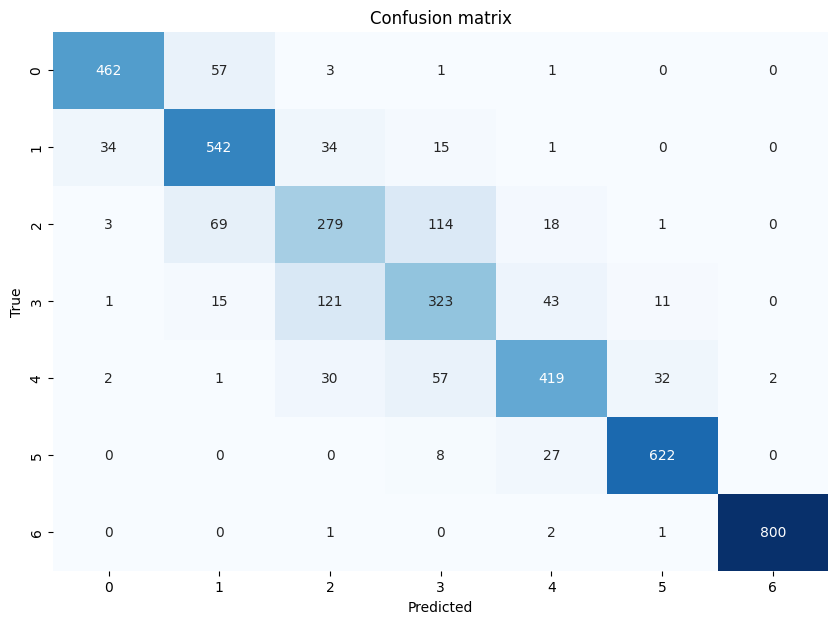

In [28]:
# Train a model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


X = df_train.drop(['NObeyesdad', 'id'], axis=1)
y = df_train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


              precision    recall  f1-score   support

           0       0.92      0.88      0.90       524
           1       0.79      0.87      0.83       626
           2       0.60      0.58      0.59       484
           3       0.62      0.63      0.63       514
           4       0.82      0.77      0.80       543
           5       0.93      0.95      0.94       657
           6       1.00      1.00      1.00       804

    accuracy                           0.83      4152
   macro avg       0.81      0.81      0.81      4152
weighted avg       0.83      0.83      0.83      4152



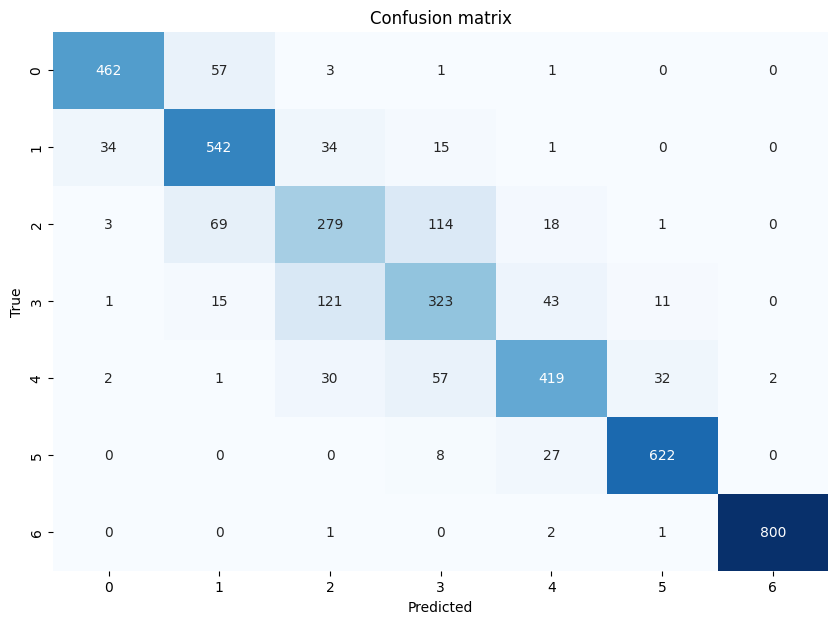

In [29]:
# Xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       524
           1       0.78      0.90      0.84       626
           2       0.65      0.57      0.61       484
           3       0.66      0.70      0.68       514
           4       0.86      0.77      0.81       543
           5       0.92      0.95      0.93       657
           6       0.99      1.00      1.00       804

    accuracy                           0.84      4152
   macro avg       0.83      0.82      0.82      4152
weighted avg       0.84      0.84      0.84      4152



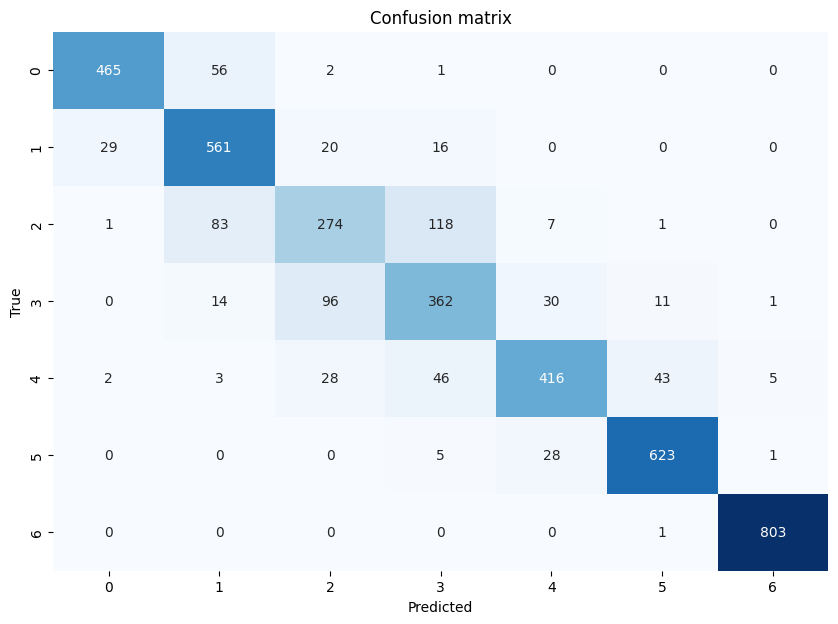

In [30]:
# SVM
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       524
           1       0.78      0.84      0.81       626
           2       0.57      0.55      0.56       484
           3       0.65      0.62      0.63       514
           4       0.82      0.76      0.79       543
           5       0.93      0.95      0.94       657
           6       0.99      1.00      1.00       804

    accuracy                           0.82      4152
   macro avg       0.80      0.80      0.80      4152
weighted avg       0.82      0.82      0.82      4152



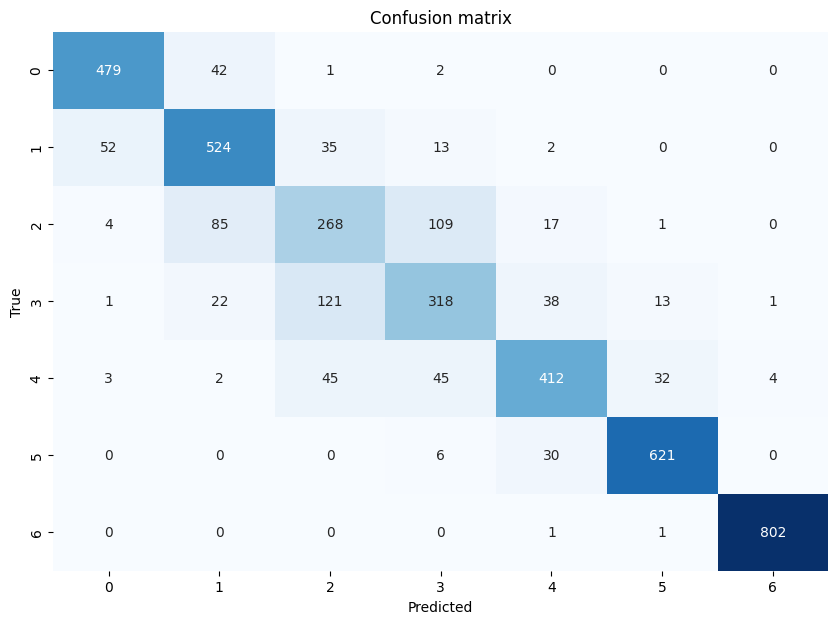

In [31]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

<Figure size 1800x700 with 0 Axes>

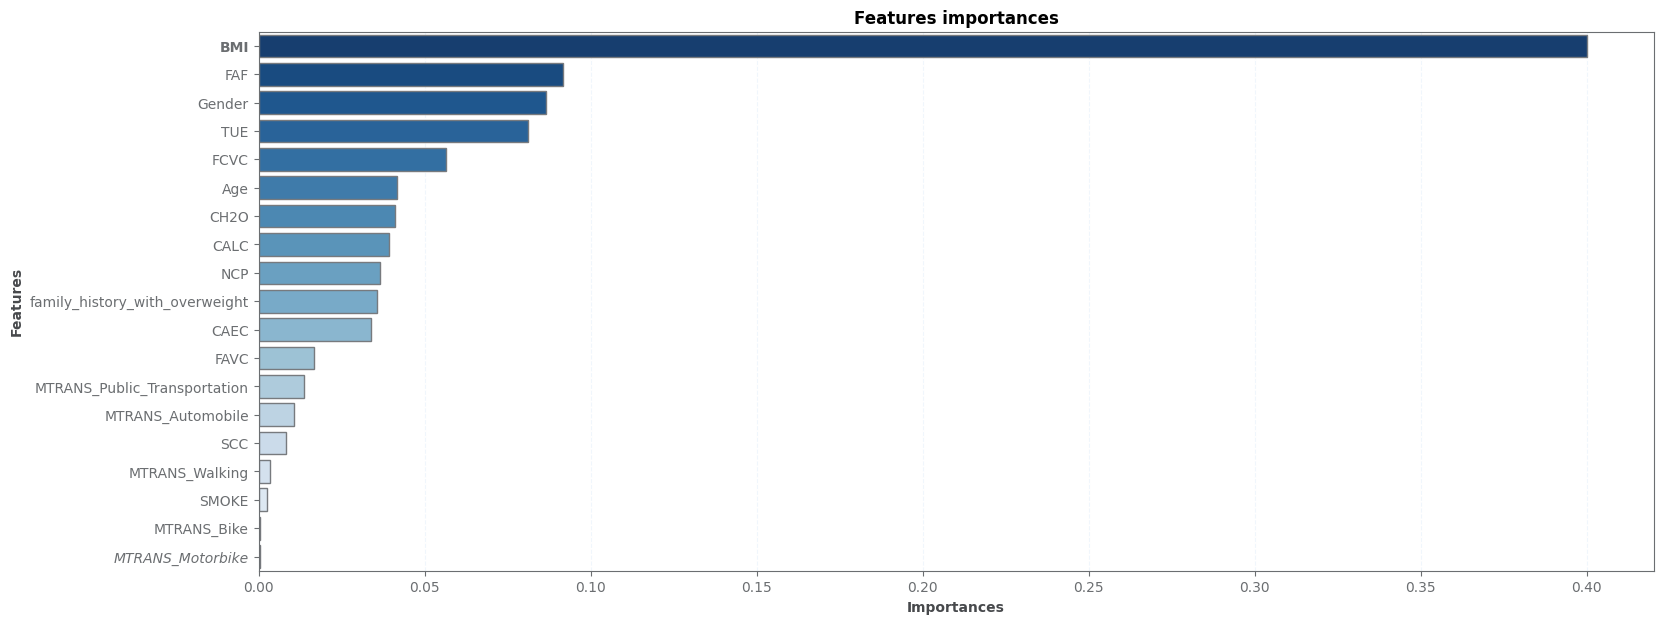

In [53]:
# Plot feature importance
plt.figure(figsize=(18, 7))
plt.figure(figsize=(18, 7))
ax = plt.subplot(1, 1, 1)
utilities.plot_feature_importance(ax, X.columns, clf.feature_importances_, color='Blues')
plt.show()

In [ ]:
# Use the model to predict the test dataset
X_test = df_test.drop(['id'], axis=1)
y_pred_clf = clf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_knn = knn.predict(X_test)

# Ensembling the models with priority to xgboost
y_pred = (y_pred_xgb * 2 + y_pred_clf * 1 + y_pred_svc + y_pred_knn) / 5
y_pred = np.round(y_pred).astype(int)

# Return a CSV id and prediction (NObeyesdad to string categories)
df_test['NObeyesdad'] = y_pred
df_test['NObeyesdad'] = df_test['NObeyesdad'].map({0: 'Insufficient_Weight', 1: 'Normal_Weight', 2: 'Overweight_Level_I', 3: 'Overweight_Level_II', 4: 'Obesity_Type_I', 5: 'Obesity_Type_II', 6: 'Obesity_Type_III'})

df_test[['id', 'NObeyesdad']].to_csv('submission.csv', index=False)
